In [30]:
import warnings
import pickle
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [31]:
# load data
with open('./datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

data=datasets['concrete']
data.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [32]:
# get info about feature types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1030 non-null   float64
 1   BlastFurnaceSlag     1030 non-null   float64
 2   FlyAsh               1030 non-null   float64
 3   Water                1030 non-null   float64
 4   Superplasticizer     1030 non-null   float64
 5   CoarseAggregate      1030 non-null   float64
 6   FineAggregate        1030 non-null   float64
 7   Age                  1030 non-null   int64  
 8   CompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [33]:
# get dataset statistics
data.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [34]:
components=['Cement',
              'BlastFurnaceSlag',
              'FlyAsh',
              'Water',
              'Superplasticizer',
              'CoarseAggregate',
              'FineAggregate']
data['Count']=data[components].gt(0).sum(axis=1)
data.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength,Count
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,5


In [35]:
# data normalization
X = StandardScaler().fit_transform(data)

pca = PCA(random_state=42).fit(X)
pve = pca.explained_variance_ratio_


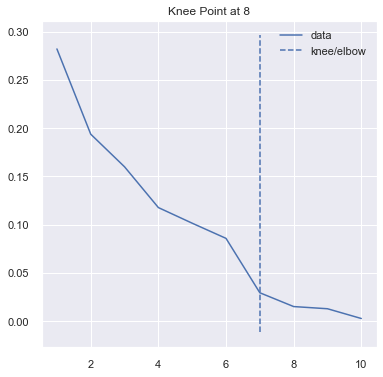

In [36]:
# visualize kneed for the given dataset
sns.set_theme()

kneedle = KneeLocator(x=range(1, len(pve)+1), y=pve, curve='convex', direction='decreasing')

kneedle.plot_knee()

plt.title(f'Knee Point at {kneedle.elbow+1}')
plt.show()

[Text(0.5, 0, 'number of components'),
 Text(0, 0.5, 'cummulative explained vatiance')]

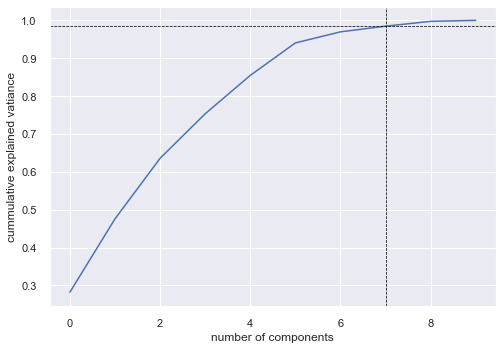

In [37]:
n_components = kneedle.elbow

ax = sns.lineplot(np.cumsum(pve))
ax.axvline(x=n_components, c='black',
           linestyle='--',
           linewidth=0.75)

ax.axhline(y=np.cumsum(pve)[n_components], c='black',
           linestyle='--',
           linewidth=0.75)

ax.set(xlabel='number of components', ylabel='cummulative explained vatiance')


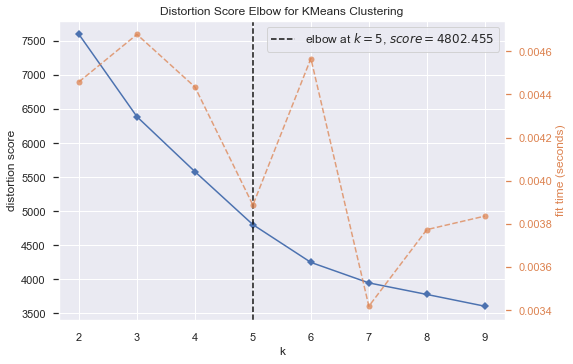

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:

X = pca.transform(X)[:, :n_components]

# define optimal number of clusters
model_kmn_vis = KMeans(random_state=42)

visualizer = KElbowVisualizer(model_kmn_vis, k=(2,10), timing=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    visualizer.fit(X)
    
visualizer.show()

In [39]:
# create clustering model
k_best = visualizer.elbow_value_

model_kmn = KMeans(n_clusters=k_best, random_state=42).fit(X)
labels_kmn=pd.Series(model_kmn.labels_, name='k-means')

labels_kmn

0       0
1       2
2       4
3       4
4       4
       ..
1025    3
1026    3
1027    3
1028    1
1029    3
Name: k-means, Length: 1030, dtype: int32

In [40]:
data['Cluster']=model_kmn.labels_
data.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength,Count,Cluster
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,5,0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,5,2
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,5,4
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,5,4
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,5,4


[Text(0.5, 1.0, 'k-means')]

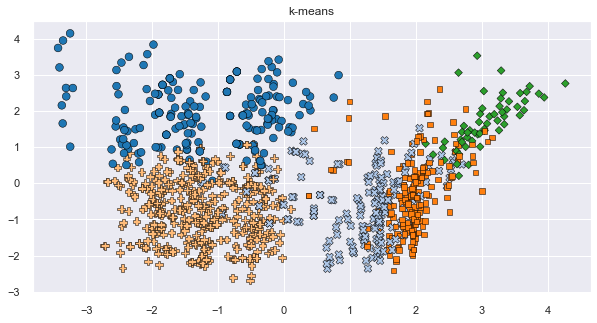

In [41]:
# Clusters visualisation
fig,ax= plt.subplots( figsize=(10, 5))

sns.scatterplot(x=X[:, 0],
                    y=X[:, 1],
                    hue=labels_kmn,
                    style=labels_kmn,
                    edgecolor='black',
                    linewidth=0.5,
                    s=60,
                    palette='tab20',
                    legend=False,
                    ax=ax)

ax.set(title=labels_kmn.name)


In [42]:
# make report dataset
report=(data.groupby('Cluster')[components]).mean()
report['Components']=(data.groupby('Cluster')['Count']).mean()
report['Count']=(data.groupby('Cluster')['Cluster']).count()
report

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components,Count
Cluster,,,,,,,,,
0,388.069388,114.278571,24.956122,161.710714,12.784694,922.529082,787.369898,6.153061,196
1,197.164571,190.698286,2.835429,195.306857,1.962286,965.159429,753.222857,5.280000,175
2,350.804592,0.739796,0.306122,190.933673,0.227551,1021.032653,776.387755,4.066327,196
3,223.223284,40.771078,123.447059,176.042402,8.571078,978.502696,788.203431,6.411765,408
4,349.176364,64.769091,0.000000,216.218182,0.000000,964.298182,670.734545,4.563636,55


Conclusion

With the help of elbow method from 'kneedle' package we defined the optimal number of clusters as 5 and performed clusterisation with the help of KMeans model. We created report dataframe, which depicts mean values for all components, number of components in one formula and total number of objects that belong to each cluster.
We can observe that clustering could be refered according to the mean value of each component in the set of objects. For example, we see that cluster 4 contains objects that don't have 'FlyAsh' and 'Superplasticizer' and cluster 2 contains only smallest amount of the apointed components. Cluster 0 contains the highest amount of 'Cement' and 'Superplasticizer'.
We can make a conclusion that our model is doing well while solving clustering based on the components amount in the given object (formula).
